In [1]:
#The following script uses decision tree regressor 
#It needs two loops find the best threshold of feature selection, and the best depth of decision tree.
#Therefore, it may take hours to run it. 
#I recommand to modify MAX_DEPTH and MIN_DEPTH to a smaller range to check this code.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline  


In [2]:
MAX_DEPTH = 20
MIN_DEPTH = 14
DEPTH_LIST = range(MIN_DEPTH, MAX_DEPTH)

# import the dataset
df = pd.read_csv("data/convert_columns_clean_data.csv")

# select needed columns.
features = [c for c in df.columns if c not in ['salary','jobId']]

# Fit regression model
global_best_score = 0
global_best_mse=0
depth_of_global_best_score = 0
thres_of_best_score = 0
threshold_list = [0, 0.002, 0.005, 0.008, 0.012, 0.015, 0.018, 0.02, 0.025]
plot_df = None
plot_list_test=[]

for thres in threshold_list:
    
    # select features
    select_feature_model = VarianceThreshold(threshold = thres)
    df_features_after_selection = pd.DataFrame(select_feature_model.fit_transform(df[features]))
    
    # split data set into 70% train set, 20% validation set and 10% test set
    df_feature_and_label_after_selection = pd.concat([df_features_after_selection, df["salary"]], axis = 1)
    train_data, validate_data, test_data = np.split(df_feature_and_label_after_selection.sample(frac=1), [int(0.7 * len(df_feature_and_label_after_selection)), int(0.9 * len(df_feature_and_label_after_selection))])

    features_after_selection = [c for c in df_features_after_selection.columns]
    train_data_features = train_data[features_after_selection]
    train_data_labels = train_data['salary']

    validate_data_features = validate_data[features_after_selection]
    validate_data_labels = validate_data['salary']

    test_data_features = test_data[features_after_selection]
    test_data_labels = test_data['salary']
    
    local_best_score = 0
    depth_of_local_best_score = 0
    best_model = None
    
    plot_list_train=[]
    for depth in DEPTH_LIST:
        
        temp_model = DecisionTreeRegressor(max_depth=depth)

        temp_model.fit(train_data_features, train_data_labels)

        # get R-squared score using validation data set
        temp_result = temp_model.predict(validate_data_features)

        r2_score_validate_set = r2_score(validate_data_labels, temp_result)
        
        plot_list_train.append(r2_score_validate_set)
         
        # update best depth for current num_of_component
        if r2_score_validate_set > local_best_score:
            local_best_score = r2_score_validate_set
            best_model = temp_model
            depth_of_local_best_score = depth
    
    # plot the r2 score of the validation set
    plot_each_df = pd.DataFrame({thres: plot_list_train}) 
    plot_df = pd.concat([plot_df, plot_each_df], axis = 1)
                       
    # predict using test data set
    result = best_model.predict(test_data_features)
    r2_score_test_data = r2_score(test_data_labels,result)
    mean_squared_error_test_data = mean_squared_error(test_data_labels, result)
    plot_list_test.append(r2_score_test_data)
    
    # update best depth and best threshold of feature selection
    if r2_score_test_data > global_best_score:
        global_best_mse=mean_squared_error_test_data
        global_best_score = r2_score_test_data
        depth_of_global_best_score = depth_of_local_best_score
        thres_of_best_score = thres
        
print("Best r2 score on test data set is: ",global_best_score, "with depth: ", depth_of_global_best_score, " with threshold of feature selection: ", thres_of_best_score, "with mean square error: ",global_best_mse)


Best r2 score on test data set is:  0.729179546163 with depth:  16  with threshold of feature selection:  0.005 with mean square error:  407.403251476


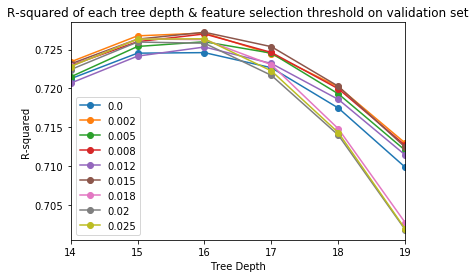

In [3]:
#visualize the results.
plot_df.index = DEPTH_LIST
ax = plot_df.plot(marker='o', title='R-squared of each tree depth & feature selection threshold on validation set')
ax.set_xlabel("Tree Depth")
ax.set_ylabel("R-squared")

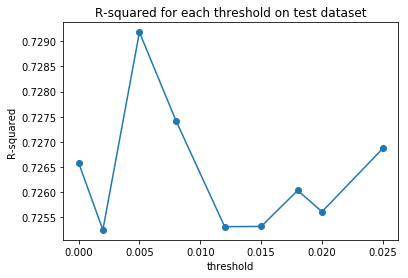

In [4]:
#visualize the result of test dataset
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots()
ax.plot(threshold_list,plot_list_test,marker='o') 
ax.set_xlabel('threshold')
ax.set_ylabel('R-squared')
ax.set_title('R-squared for each threshold on test dataset')

# Boosting using best tree depth and best threshold of feature selection. 
It is clear that the convergence point of boosting is diferent from the one of Decision Tree Regression. However, using boosting to test every parameter is really time consuming. As a result, I only use the best parameter calculated from regression for boosting. The difference is small so it is negligible.

In [5]:
# select features using best threshold
select_feature_model = VarianceThreshold(threshold = thres_of_best_score)
df_features_after_selection = pd.DataFrame(select_feature_model.fit_transform(df[features]))
    
# split data set into 80% train set and 20% test set
df_feature_and_label_after_selection = pd.concat([df_features_after_selection, df["salary"]], axis = 1)
train_data, test_data = np.split(df_feature_and_label_after_selection.sample(frac = 1), [int(0.8 * len(df_feature_and_label_after_selection))])

features_after_selection = [c for c in df_features_after_selection.columns]
train_data_features = train_data[features_after_selection]
train_data_labels = train_data['salary']

test_data_features = test_data[features_after_selection]
test_data_labels = test_data['salary']
    
# make regression model using best alpha
decision_tree = DecisionTreeRegressor(max_depth = depth_of_global_best_score)
boost = AdaBoostRegressor(decision_tree)
boost.fit(train_data_features, train_data_labels)

# make prediction
result = boost.predict(test_data_features)
r2_score_test_set = r2_score(test_data_labels,result)
mean_squared_error_test_set = mean_squared_error(test_data_labels, result)
        
print("R2 score after boosting is: ", r2_score_test_set)
print('mean squared error after boosting is: ', mean_squared_error_test_set)

R2 score after boosting is:  0.756378668304
mean squared error after boosting is:  366.327276838


# Boosting significantly improves the result of Decision Tree Regression